#Download data from kaggle 

In [5]:
!pip install kaggle

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [7]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:40<00:00, 27.3MB/s]
100% 2.29G/2.29G [00:41<00:00, 60.1MB/s]


In [8]:
!unzip -q chest-xray-pneumonia.zip

unzip:  cannot find or open chest_xray.zip, chest_xray.zip.zip or chest_xray.zip.ZIP.


#Check dataset

In [0]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import numpy as np
import os

In [0]:
# Setting the directories for the dataset
TRAIN_PATH = '/content/chest_xray/train'
TEST_PATH = '/content/chest_xray/test'
VAL_PATH = '/content/chest_xray/val'

In [0]:
# Function to plot the images
def plot_img(path, labeled=False, max_count=9):
    img_count = 0
    fig = plt.figure(figsize=(16,8))

    for file in os.listdir(path):
        if file.endswith('.jpeg'):
            if img_count == max_count:
                break
            
            img = mpimg.imread(os.path.join(path + file))
            plt.subplot(331+img_count)
            if labeled:
                plt.title(file.split('_')[1])
            imgplot = plt.imshow(img)

            img_count += 1

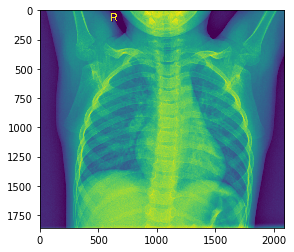

In [12]:
img = mpimg.imread(TRAIN_PATH + '/NORMAL/IM-0115-0001.jpeg')
imgplot = plt.imshow(img)
plt.show()

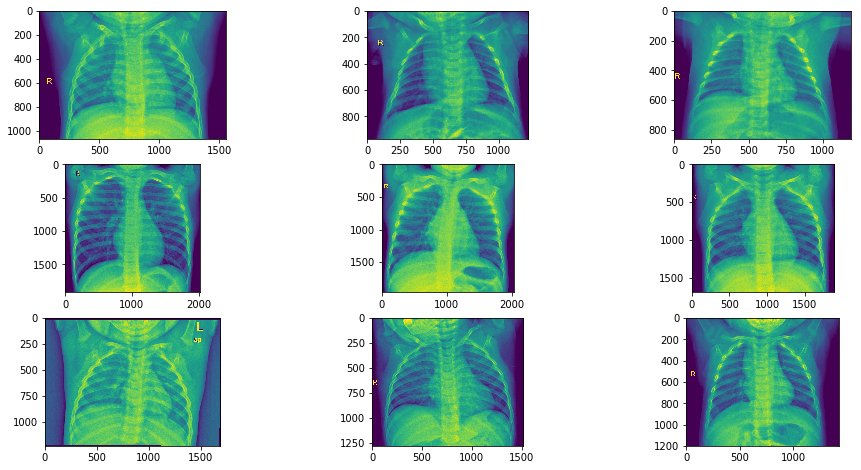

In [13]:
path = TRAIN_PATH + '/NORMAL/'
plot_img(path)

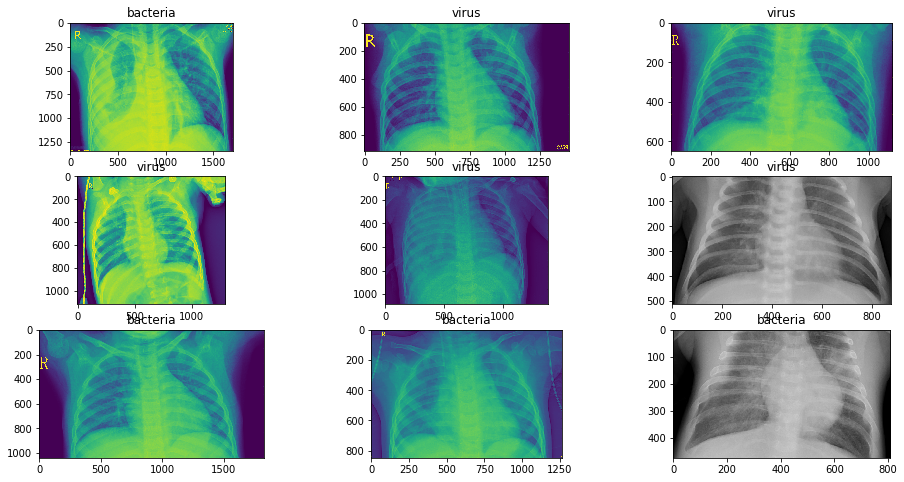

In [14]:
path = TRAIN_PATH + '/PNEUMONIA/'
plot_img(path, labeled=True)

#Train model

In [15]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D, SeparableConv2D
from keras import models
from keras.models import Model

Using TensorFlow backend.


In [16]:
rescale = 1./255.0
target_size = (150, 150)
batch_size = 32
class_mode = "categorical"

train_datagen = ImageDataGenerator(
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    rescale = rescale,
    preprocessing_function = preprocess_input
)

train_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    class_mode = class_mode,
    batch_size = batch_size,
    target_size = target_size
)

val_datagen = ImageDataGenerator(rescale=rescale)

val_generator = val_datagen.flow_from_directory(
    VAL_PATH,
    class_mode = class_mode,
    batch_size = batch_size,
    target_size = target_size
)

test_datagen = ImageDataGenerator(rescale=rescale)

test_generator = test_datagen.flow_from_directory(
    TEST_PATH,
    class_mode = class_mode,
    batch_size = batch_size,
    target_size = target_size
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [0]:
def get_model():
    base_model = InceptionV3(weights='imagenet', include_top=False)
    x = base_model.output
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(1024, activation='relu')(x)
    x = keras.layers.BatchNormalization()(x)
    predictions = keras.layers.Dense(2, activation='softmax')(x)
    model = keras.models.Model(input=base_model.input, output=predictions)

    for layer in base_model.layers:
        layer.trainable = False

    model.summary()
    return model

In [18]:
model = get_model()









87916544/87910968 [==============================] - 1s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
___________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  


In [19]:
model.compile(keras.optimizers.Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit_generator(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs = 5,
    verbose=1,
    validation_data = val_generator,
    validation_steps = len(val_generator)
)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/5
163/163 [==============================] - 332s 2s/step - loss: 0.3905 - acc: 0.8616 - val_loss: 1.7402 - val_acc: 0.6875
Epoch 2/5
163/163 [==============================] - 327s 2s/step - loss: 0.2627 - acc: 0.8982 - val_loss: 1.2083 - val_acc: 0.6250
Epoch 3/5
163/163 [==============================] - 330s 2s/step - loss: 0.2516 - acc: 0.9001 - val_loss: 3.0124 - val_acc: 0.5625
Epoch 4/5
163/163 [==============================] - 331s 2s/step - loss: 0.2643 - acc: 0.8967 - val_loss: 0.6669 - val_acc: 0.6875
Epoch 5/5
163/163 [==============================] - 331s 2s/step - loss: 0.2592 - acc: 0.8955 - val_loss: 1.4058 - val_acc: 0.5625


#Evaluate model

In [20]:
result = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print('Loss:', result[0])
print('Accuracy:', result[1])

20/20 [==============================] - 41s 2s/step
Loss: 1.3401406208674114
Accuracy: 0.6346153846153846


In [21]:
y_pred_batches = []
y_true_batches = []
y_img_batches = []

for i in range(0, len(test_generator)):
    y_img_batch, y_true_batch = test_generator[i]
    y_true_batch = y_true_batch.argmax(axis=-1)
    y_img_batches.append(y_img_batch)
    y_true_batches.append(y_true_batch)

    y_pred_batch = model.predict(y_img_batch)
    y_pred_batch = y_pred_batch.argmax(axis=-1)
    y_pred_batches.append(y_pred_batch)

y_pred_batches

[array([1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1]),
 array([0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0,
        1, 1, 0, 1, 1, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1,
        1, 0, 0, 1, 1, 0, 0, 0, 1, 0]),
 array([0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1,
        0, 1, 0, 0, 1, 1, 0, 0, 0, 1]),
 array([0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
        1, 0, 0, 1, 1, 1, 1, 1, 1, 0]),
 array([1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1,
        1, 1, 0, 1, 0, 1, 0, 1, 0, 1]),
 array([1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 1, 0, 1, 1, 1]),
 array([1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 1, 0, 0, 0, 1]),
 array([0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
        0, 1, 

#Test model (visually)

In [0]:
def predict_images(images_path, label):
  amount = 0
  fig = plt.figure(figsize=(18, 8))

  for file in os.listdir(images_path):
    if file.endswith('.jpeg'):
      if amount == 8:
        break

      img = mpimg.imread(os.path.join(images_path, file))
      plt.subplot(241+amount)
      plt.title('{} ---- {}'.format(label, 'NORMAL' if y_pred_batches[amount][0] == 0 else 'PNEUMONIA'))
      imgplot = plt.imshow(img)

      amount += 1

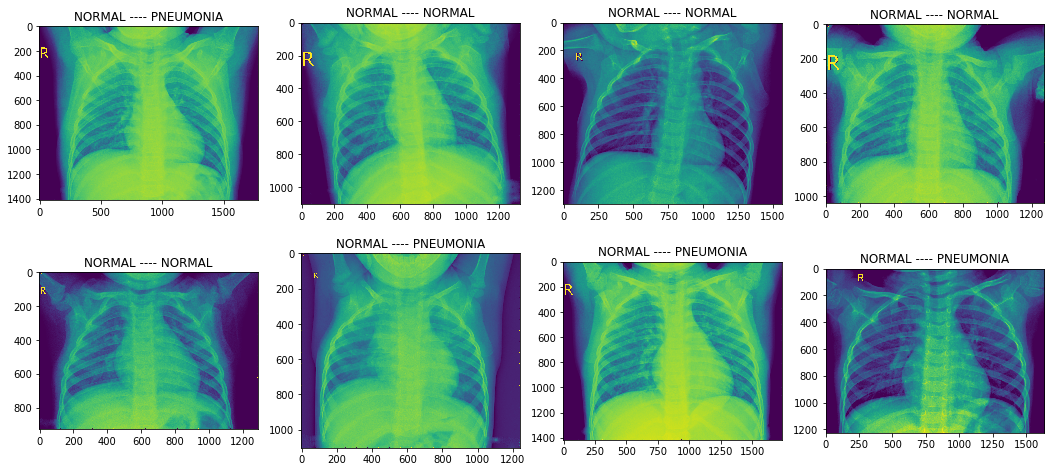

In [23]:
predict_images('./chest_xray/val/NORMAL', 'NORMAL')

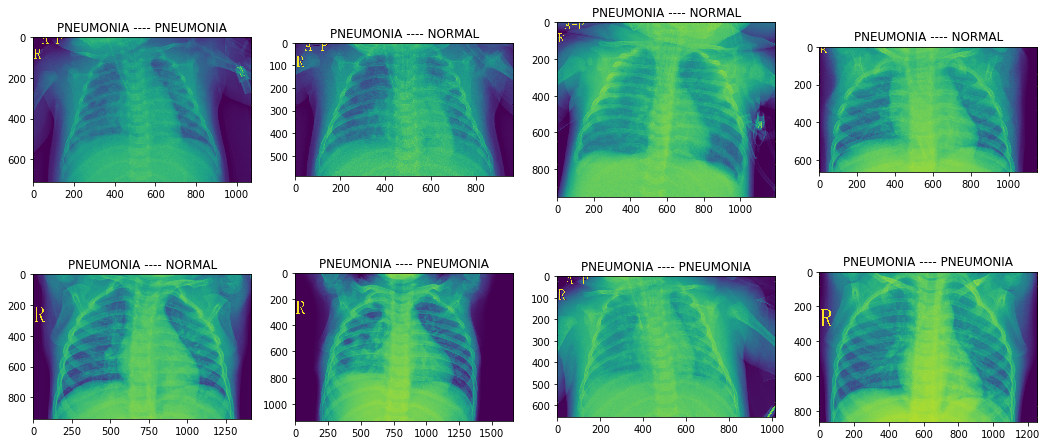

In [24]:
predict_images('./chest_xray/val/PNEUMONIA', 'PNEUMONIA')

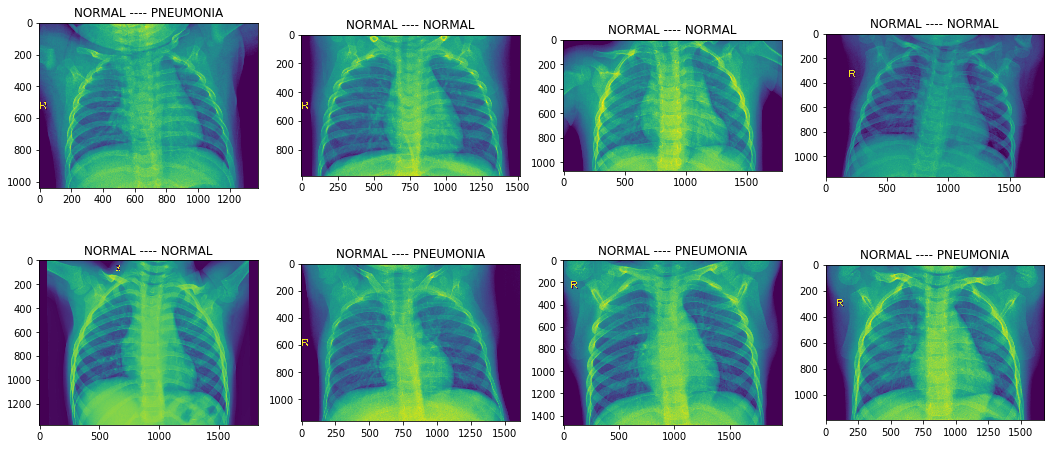

In [25]:
predict_images('./chest_xray/test/NORMAL', 'NORMAL')

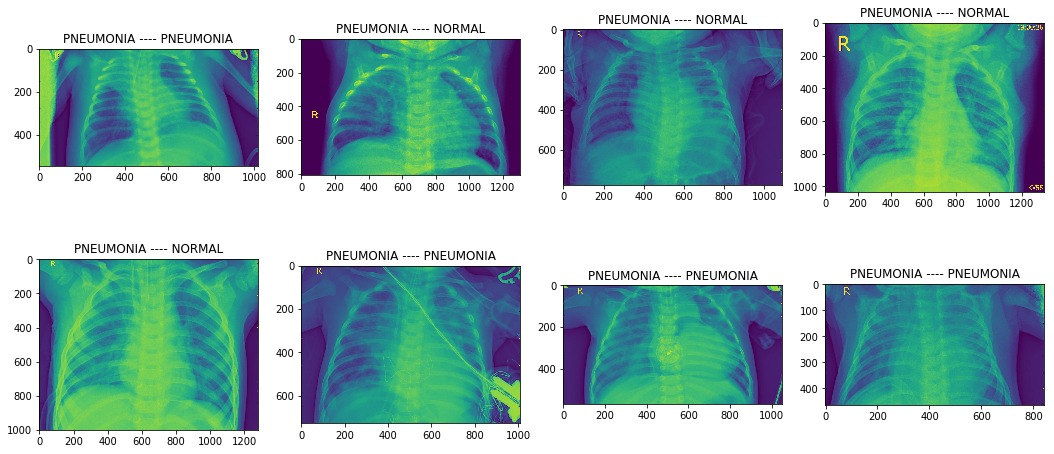

In [26]:
predict_images('./chest_xray/test/PNEUMONIA', 'PNEUMONIA')

#Model save and load

In [0]:
model.save('pneumonia_kaggle.h5')

In [0]:
new_model = keras.models.load_model('pneumonia_kaggle.h5')